### Load in Libraries and Data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix

In [5]:
# Create function to convert colors: rgb_colors
def rgb_color(r,g,b):
    r = r/255.
    g = g/255.
    b = b/255.
    return(r,g,b)

# Create colors:
tableau_blue = rgb_color(31,119,180)
tableau_grey = rgb_color(127,127,127)

In [4]:
# Load in data: df
df = pd.read_csv('https://s3.amazonaws.com/clcarverloans/data/df_cluster.csv')

In [5]:
# Remove usesless rows: df_select
cols = ['Borrower_Genders', 'Country Code', 'Loan Amount', 'Lender_Term', 'Repayment_Interval', 'Distribution_Model', 'Sector', 'Activity','Cluster','Delinquent']
df_select = df[cols]
df_select = df_select.dropna()

In [6]:
# One_hot_encode categorical columns: df_dummies
df_dummies = pd.get_dummies(df_select)

In [13]:
import csv
full_col = df_dummies.columns
with open('full_col.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(full_col)

In [14]:
with open('../data/full_col.csv') as f:
    full_dummies = f.read().splitlines()

In [6]:
# Remove usesless rows: df_select
cols = ['Borrower_Genders', 'Country Code', 'Loan Amount', 'Lender_Term', 'Repayment_Interval', 'Distribution_Model', 'Sector', 'Activity','Cluster','Delinquent']
df_select = df[cols]
df_select = df_select.dropna()

# One_hot_encode categorical columns: df_dummies
df_dummies = pd.get_dummies(df_select)

# Select features and target: X, y
y = df_dummies.pop('Delinquent')
X = df_dummies

# Split data into train and test set: train_set, test_set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Evaluate the Baseline Model

In [7]:
def modelfit(model, X_train, X_test, y_train, y_test, performCV=True, printFeatureImportance=True, cv_folds=5):
    
    #Fit the algorithm on the data
    model.fit(X_train, y_train)
        
    #Predict training set:
    y_pred = model.predict(X_test)
    y_predprob = model.predict_proba(X_test)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='roc_auc')
    
    CM = confusion_matrix(y_test, y_pred)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : {}".format(accuracy_score(y_test, y_pred)))
    print ("AUC Score : {}".format(roc_auc_score(y_test, y_predprob)))
    print ("Recall Score : {}".format(recall_score(y_test, y_pred)))
    print ("Precision Score : {}".format(precision_score(y_test, y_pred)))
    print ('FPR : {}'.format(FP/(FP+TN)))
    
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending=False)
        feat_imp.iloc[0:10].plot(kind='bar', title='Feature Importances', color=tableau_blue)
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9828661280702705
AUC Score : 0.9838190513553403
Recall Score : 0.52
Precision Score : 0.9176470588235294
FPR : 0.001569242840329541


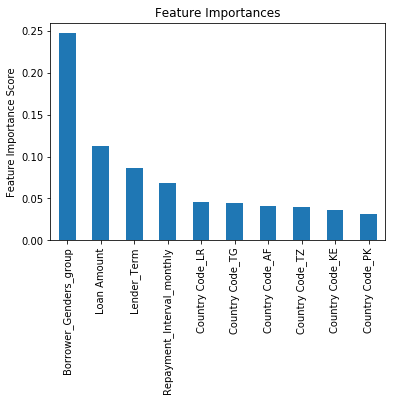

In [9]:
gbm_baseline = GradientBoostingClassifier()
modelfit(gbm_baseline, X_train, X_test, y_train, y_test, performCV=False)

### Hyper-tune Parameters

In [7]:
# Hypertune n_estimators
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5, verbose=True)
gsearch1.fit(X_train, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:  1.7min finished


([mean: 0.98407, std: 0.00316, params: {'n_estimators': 20},
  mean: 0.98545, std: 0.00278, params: {'n_estimators': 30},
  mean: 0.98625, std: 0.00270, params: {'n_estimators': 40},
  mean: 0.98684, std: 0.00268, params: {'n_estimators': 50},
  mean: 0.98730, std: 0.00264, params: {'n_estimators': 60},
  mean: 0.98760, std: 0.00284, params: {'n_estimators': 70},
  mean: 0.98792, std: 0.00262, params: {'n_estimators': 80}],
 {'n_estimators': 80},
 0.9879219025166895)

In [8]:
# Hypertune max_depth and min_samples_split
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5, verbose=True)
gsearch2.fit(X_train, y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed: 11.9min finished


([mean: 0.98587, std: 0.00256, params: {'max_depth': 5, 'min_samples_split': 200},
  mean: 0.98560, std: 0.00323, params: {'max_depth': 5, 'min_samples_split': 400},
  mean: 0.98538, std: 0.00290, params: {'max_depth': 5, 'min_samples_split': 600},
  mean: 0.98531, std: 0.00288, params: {'max_depth': 5, 'min_samples_split': 800},
  mean: 0.98530, std: 0.00308, params: {'max_depth': 5, 'min_samples_split': 1000},
  mean: 0.98693, std: 0.00280, params: {'max_depth': 7, 'min_samples_split': 200},
  mean: 0.98672, std: 0.00262, params: {'max_depth': 7, 'min_samples_split': 400},
  mean: 0.98695, std: 0.00284, params: {'max_depth': 7, 'min_samples_split': 600},
  mean: 0.98670, std: 0.00273, params: {'max_depth': 7, 'min_samples_split': 800},
  mean: 0.98642, std: 0.00273, params: {'max_depth': 7, 'min_samples_split': 1000},
  mean: 0.98790, std: 0.00203, params: {'max_depth': 9, 'min_samples_split': 200},
  mean: 0.98827, std: 0.00191, params: {'max_depth': 9, 'min_samples_split': 400},
  

In [9]:
# Tuning min_samples_split and min_samples_leaf
param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train, y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.98757, std: 0.00258, params: {'min_samples_leaf': 30, 'min_samples_split': 1000},
  mean: 0.98755, std: 0.00262, params: {'min_samples_leaf': 30, 'min_samples_split': 1200},
  mean: 0.98767, std: 0.00230, params: {'min_samples_leaf': 30, 'min_samples_split': 1400},
  mean: 0.98743, std: 0.00269, params: {'min_samples_leaf': 30, 'min_samples_split': 1600},
  mean: 0.98727, std: 0.00287, params: {'min_samples_leaf': 30, 'min_samples_split': 1800},
  mean: 0.98755, std: 0.00224, params: {'min_samples_leaf': 30, 'min_samples_split': 2000},
  mean: 0.98754, std: 0.00237, params: {'min_samples_leaf': 40, 'min_samples_split': 1000},
  mean: 0.98741, std: 0.00234, params: {'min_samples_leaf': 40, 'min_samples_split': 1200},
  mean: 0.98735, std: 0.00258, params: {'min_samples_leaf': 40, 'min_samples_split': 1400},
  mean: 0.98747, std: 0.00273, params: {'min_samples_leaf': 40, 'min_samples_split': 1600},
  mean: 0.98747, std: 0.00276, params: {'min_samples_leaf': 40, 'min_samples_spl

In [10]:
# Tune max_features
param_test4 = {'max_features':range(7,20,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9, min_samples_split=1200, min_samples_leaf=60, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train, y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.98531, std: 0.00301, params: {'max_features': 7},
  mean: 0.98655, std: 0.00281, params: {'max_features': 9},
  mean: 0.98604, std: 0.00293, params: {'max_features': 11},
  mean: 0.98668, std: 0.00263, params: {'max_features': 13},
  mean: 0.98752, std: 0.00247, params: {'max_features': 15},
  mean: 0.98765, std: 0.00238, params: {'max_features': 17},
  mean: 0.98781, std: 0.00231, params: {'max_features': 19}],
 {'max_features': 19},
 0.9878125148154429)

In [12]:
# Subsample 
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9,min_samples_split=1200, min_samples_leaf=60, subsample=0.8, random_state=10,max_features=7),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5, verbose=True)
gsearch5.fit(X_train, y_train)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  1.0min finished


([mean: 0.98546, std: 0.00263, params: {'subsample': 0.6},
  mean: 0.98532, std: 0.00302, params: {'subsample': 0.7},
  mean: 0.98581, std: 0.00277, params: {'subsample': 0.75},
  mean: 0.98531, std: 0.00301, params: {'subsample': 0.8},
  mean: 0.98539, std: 0.00322, params: {'subsample': 0.85},
  mean: 0.98554, std: 0.00285, params: {'subsample': 0.9}],
 {'subsample': 0.75},
 0.9858105299669427)


Model Report
Accuracy : 0.984113213685409
AUC Score : 0.9887993424125241
Recall Score : 0.6083333333333333
Precision Score : 0.8628841607565012
FPR : 0.0032505744549683347


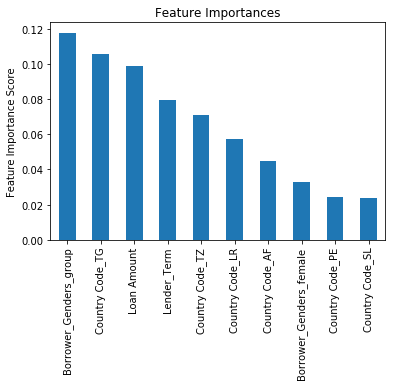

In [10]:
gbm_tuned1 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=15, min_samples_split=1000, min_samples_leaf=70, subsample=0.75, random_state=10, max_features=19)
modelfit(gbm_tuned1, X_train, X_test, y_train, y_test, performCV=False)


Model Report
Accuracy : 0.9837878870031991
AUC Score : 0.9889490276298829
Recall Score : 0.5883333333333334
Precision Score : 0.8716049382716049
FPR : 0.002914308132040576


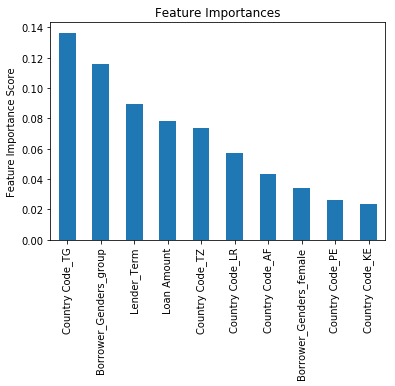

In [11]:
gbm_tuned2 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1200,max_depth=15, min_samples_split=1000, min_samples_leaf=70, subsample=0.75, random_state=10, max_features=19)
modelfit(gbm_tuned2, X_train, X_test, y_train, y_test, performCV=False)

### Save and Pickle Final Model

In [40]:
# Save final model: final_model
import pickle
with open('../scripts/final_model.pkl', 'wb') as output:
    pickle.dump(gbm_tuned2, output, pickle.HIGHEST_PROTOCOL)